In [1]:
#### Field Plots #####
import os
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
import math
from scipy.stats import norm
import seaborn as sns
import xarray as xr
import netCDF4 as nc
import sys

sys.setrecursionlimit(100000)
###########################################################################################################################
def make_netcdffile_fromcross(time_start, time_end, time_gap, x_spacing, variable_name, path, output_name, del_files): 
    float_type = 'f4'
    time_ind_total = int((time_end-time_start)/time_gap) + 1
    time = np.linspace(time_start,time_end,time_ind_total)
    filename = path+variable_name + str(format(int(time[0]),'07d'))
    fid=open(filename,'rb')
    x_length = int(np.sqrt(len(np.fromfile(fid))))
    x=np.linspace(x_spacing,x_length*x_spacing,x_length)
    y=np.linspace(x_spacing,x_length*x_spacing,x_length)
    fid.close()
    if os.path.exists(path+output_name):
        os.remove(path+output_name)
    nc_file = nc.Dataset(path+output_name, mode="w", datamodel="NETCDF4", clobber=False)
    nc_file.createDimension("x", x_length)
    nc_file.createDimension("y", x_length)
    nc_file.createDimension("t", time_ind_total)
    nc_x = nc_file.createVariable("x", float_type, ("x"))
    nc_y = nc_file.createVariable("y", float_type, ("y"))
    nc_t = nc_file.createVariable("t", float_type, ("t"))
    var_name = variable_name.split('.')[0]
    locals()[var_name] = np.zeros((x_length,x_length,time_ind_total))
    locals()['nc_'+var_name] = nc_file.createVariable(var_name, float_type, ("x","y","t"))                    
    for i in range(0,time_ind_total):
        filename = path+variable_name+str(format(int(time[i]),'07d'))
        fid=open(filename,'rb')
        var = np.fromfile(fid)
        locals()[var_name][:,:,i]=np.reshape(var,[x_length,x_length])
        fid.close()
    locals()['nc_'+var_name][:] = locals()[var_name][:]




    nc_x [:] = x[:]
    nc_y [:] = y[:]
    nc_t [:] = time[:]
    nc_file.close()
    if del_files:
        #files = ["u", "v", "w", "thl", "time", "qr", "ql", "couv", "grid", "nr","qt","therm","bc"]
        files = [variable_name]
        for file in os.listdir(path):
            for i in range(0,len(files)):
                if file.find(files[i])!=-1: 
                    os.remove(path+file)
                #rm u* v* w* thl* time* qr* ql* couv* grid* nr* qt* therm* 
##########################################################################################
class cell:
    def __init__(self, id):
        self.id = id
        self.value = [[],[]]
        self.location = [[],[]]
        self.nelements = 0
        self.nelements_local = 0

    def add_elements(self, i, j, var_values):
        self.location[0].append(i)
        self.location[1].append(j)
        self.value[0].append(var_values)
        self.nelements = self.nelements + 1
        self.nelements_local = self.nelements_local + 1
    def __del__(self):
        return
##########################################################################################
def find_boolean(variable, threshold_criteria): #variable is f(i, j, t): --> outputs boolean -1 (unsatisfied) 0 (satisfied) 
    boolean = np.zeros(( len(variable[:,0]), len(variable[0,:])))
    boolean = -1
    boolean = np.where(variable[:,:]>threshold_criteria,0,-1)
    return boolean;
########################################################################################
def identify_elements_in_cell(i,j,new_cell):  #input the ijk at which boolean is satisfied along with boolean and new cell created 

    global booli;
    new_cell.add_elements(i,j,cell_variable[i,j])
    booli[i,j] = -1

    ii=i-1; jj=j; #look west
    if ii<0:
       ii = nx-1
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i+1; jj=j;  #look east
    if ii>nx-1:
       ii = 0
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i; jj=j+1;  #look north
    if jj>ny-1:
        jj = 0
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i; jj=j-1;  #look south
    if jj<0:
       jj = ny-1
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell) 
#################################################################################################
def create_new_cell(variable,bool):                                # input the boolean and the variable, output is the cells tracked (i,j,t) based on boolean 
    cell_number = 0;
    global booli,cell_variable,nx,ny;
    nx = len(variable[:,0])
    ny = len(variable[0,:])
    booli=bool;cell_variable = variable;
    variable_cells = []
    for j in range(0,ny):
        for i in range(0,nx):
            if booli[i,j]==0: 
                new_cell=cell(cell_number) 
                identify_elements_in_cell(i,j,new_cell)
                if new_cell.nelements>=nminelems:
                    variable_cells.append(new_cell)
                    variable_cells[cell_number].id = cell_number
                    cell_number = cell_number + 1
                else:
                    del new_cell;
    return variable_cells, cell_number;
#################################################################################################
def run_tracking(tracked_variable,param_threshold):
    global nx,ny;
    nx = len(tracked_variable[:,0]); ny = len(tracked_variable[0,:]); 
    bool = find_boolean(tracked_variable,param_threshold)
    [cells,cell_number] = create_new_cell(tracked_variable,bool);
    return cells,cell_number;
####################################################################################################
def find_cell_centers(cells,ncells):
    centers=np.zeros((ncells,2))
    for i in range(0,ncells):
        centers[i,0]=np.mean(cells[i].location[0])
        centers[i,1]=np.mean(cells[i].location[1])
    return centers;
####################################################################################################
def find_nearest_neighbor(centers,nx,ny):
    distance=np.zeros(len(centers[:,0]))
    nn_distance=np.zeros(len(centers[:,0]))
    for i in range(len(centers[:,0])):
        for j in range(len(centers[:,0])):
            if i==j:
                distance[j]=100;
            else:
                xdist=min(abs(centers[i,0]+nx-centers[j,0]),abs(centers[i,0]-nx-centers[j,0]),abs(centers[i,0]-centers[j,0]))
                ydist=min(abs(centers[i,1]+ny-centers[j,1]),abs(centers[i,1]-ny-centers[j,1]),abs(centers[i,1]-centers[j,1]))
                distance[j]=math.sqrt(xdist**2+ydist**2)
        nn_distance[i]=min(distance)
    return nn_distance;
####################################################################################################
def retrieve_variable(variable_name,netcdf_path): #open corresponding netcdf file and read data
    all_data=xr.open_dataset(netcdf_path)
    var=all_data[variable_name].values
    variable=var
    x=all_data['x'].values
    y=all_data['y'].values
    t=all_data['t'].values
    return variable, x, y, t;    
##########################################################################################
#[w_cross,x,y,t]=retrieve_variable(variable_name='w',netcdf_path='/fs/ess/PFS0220/eurec4a/case_1060lagtraj_feb2_withw/w_cross.nc')
def get_iorg(variable,param_threshold,start_ind,stop_ind):
    i_org=np.zeros(len(variable[0,0,start_ind:stop_ind+1]))
    for i in range(0,stop_ind-start_ind+1):
        [updraft,ncells]=run_tracking(tracked_variable=variable[:,:,start_ind+i],param_threshold=param_threshold)
        if ncells<2:
            i_org[i]=0;
        else:
            centers=find_cell_centers(updraft,ncells)
            nn_distance=find_nearest_neighbor(centers,nx,ny)
            centers=centers.astype(int)
            nn_sorted = np.sort(nn_distance);nn_sorted=nn_sorted/max(nn_sorted)
            p = 1. * np.arange(len(nn_distance)) / (len(nn_distance) - 1)
            p_ran=1-np.exp(-1*(math.pi)*nn_sorted*nn_sorted)
            i_org[i]=np.trapz(p,x=p_ran)
        if i==0 and ncells>2:
            pl.figure()
            pl.contour(x/1000,y/1000,variable[:,:,start_ind+i]>1)
            pl.title('w > 1 ms$^-1$ at z = 800 m')
            pl.xlabel('X (km)')
            pl.ylabel('Y (km)')
            pl.show()
            
            pl.figure()
            center_arr=np.zeros((nx,ny))
            center_arr[(centers[:,0]),(centers[:,1])]=1;
            pl.contour(x/1000,y/1000,center_arr)
            pl.xlabel('x')
            pl.ylabel('y')
            pl.title('Centroids of Updrafts')

            pl.figure()
            pl.plot(nn_sorted,p,nn_sorted,p_ran)
            pl.xlabel('x (NN Distance)')
            pl.ylabel('p=F(x)')

            pl.figure()
            pl.plot(p_ran,p)
            pl.xlabel('Random CDF')
            pl.ylabel('NNCDF')            

        print(i)
    return i_org;
#########################################################################################

nc_path='/fs/ess/PFS0220/eurec4a/case_jan28/'
nc_path='/fs/ess/PFS0220/eurec4a/case_feb2nd_testsp/'
make_netcdffile_fromcross(time_start=0,time_end=3843,time_gap=9,x_spacing=200,variable_name='qlpath.xy.',path=nc_path,output_name='qlpath.nc',del_files=False)



FileNotFoundError: [Errno 2] No such file or directory: '/fs/ess/PFS0220/eurec4a/case_feb2nd_testsp/qlpath.xy.0000000'

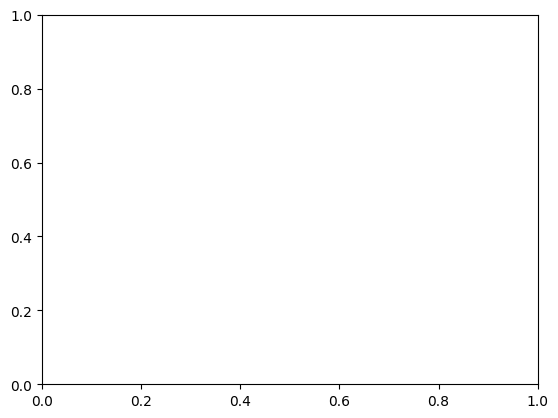

In [5]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as pl
import math
import matplotlib.animation as manimation
from IPython.display import HTML
from matplotlib import rc
from matplotlib import cm
from datetime import datetime, timedelta

start_time=datetime(2020,1,30,00)

def retrieve_variable(variable_name,netcdf_path): #open corresponding netcdf file and read data
    all_data=xr.open_dataset(netcdf_path)
    var=all_data[variable_name].values
    variable=var
    x=all_data['x'].values
    y=all_data['y'].values
    t=all_data['time'].values
    return variable, x, y, t;   


def make_animation_contour(x,y,variable,nt):
    levs=np.concatenate((np.linspace(0,0.01,20),np.linspace(0.011,1,1)))
    fig, ax = pl.subplots()
    def animate(i):
        ax.clear()
        CS = ax.contourf(x/1000,y/1000,variable[i,:,:],levels=levs,cmap=cm.gray)
        ax.set_title(f'time={start_time+timedelta(hours=hr1+i/4)}')
        ax.set_xlabel('X (km)')
        ax.set_ylabel('Y (km)')
        return ax;
        
    ani = manimation.FuncAnimation(fig,animate,frames=nt,repeat=False)
    pl.show()
    HTML(ani.to_jshtml())
    pl.rcParams["animation.html"] = "jshtml"
    return ani

directory_qlpath='/fs/ess/PFS0220/eurec4a/case_jan28/qlpath.nc'
directory_qlpath='/fs/ess/PFS0220/eurec4a/case_feb2nd_1600_100m/ql_path.xy.nc'
#directory_qlpath='/fs/ess/PFS0220/LSM/SGP/SGP_20170509_12hrbefore/qlpath.nc'
qlpath,x,y,t = retrieve_variable('ql_path',directory_qlpath)

f = r"/fs/ess/PFS0220/eurec4a/animations/animation_feb2_74to106hrs_12km_SP.gif"
#f = r"/fs/ess/PFS0220/LSM/animations/SGP_20170509_80m.gif"

hr1=74;hr2=106;
ani1=make_animation_contour(x,y,qlpath[np.absolute(t-hr1*3600).argmin():np.absolute(t-hr2*3600).argmin(),:,:],len(t[np.absolute(t-hr1*3600).argmin():np.absolute(t-hr2*3600).argmin()]))
writergif = manimation.PillowWriter(fps=5) 
ani1.save(f, writer=writergif)

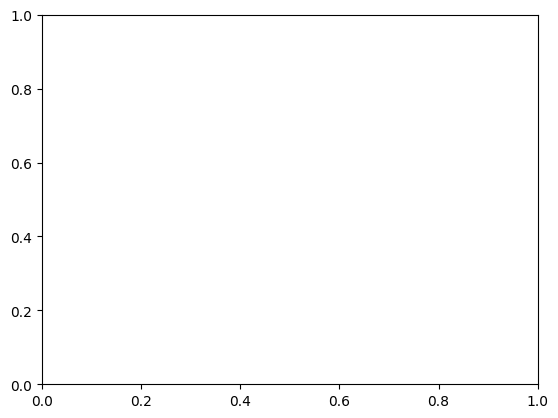

ValueError: DataArray must be 2d

In [3]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as pl
import math
import matplotlib.animation as manimation
from IPython.display import HTML
from matplotlib import rc
from matplotlib import cm


def make_animation_contour(xrdata,variable):
    levs=np.concatenate((np.linspace(0,0.01,20),np.linspace(0.011,1,1)))
    fig, ax = pl.subplots()
    def animate(i):
        ax.clear()
        CS = xrdata[variable].isel(t=slice(np.absolute(t-hr1*36).argmin(),np.absolute(t-hr2*36).argmin())).plot.contourf(levels=levs,cmap=cm.gray)
        ax.CS
        return ax;
    t= xrdata['t'].values   
    ani = manimation.FuncAnimation(fig,animate,frames=np.absolute(t-hr2*36).argmin()-np.absolute(t-hr1*36).argmin(),repeat=False)
    pl.show()
    HTML(ani.to_jshtml())
    pl.rcParams["animation.html"] = "jshtml"
    return ani

xrdata = xr.open_dataset('/fs/ess/PFS0220/eurec4a/case_feb2nd_specific_final_200m_512_varlln/qlpath.nc')

f = r"/fs/ess/PFS0220/eurec4a/animations/animation_200m_512_varln_90to106hrs_jan30.gif" 
hr1=70;hr2=106;
ani1=make_animation_contour(xrdata=xrdata,variable='qlpath')
writergif = manimation.PillowWriter(fps=5) 
ani1.save(f, writer=writergif)